## LSTM Subject-Verb number agreement
### Predicting if the verb for a subject should be plural or singular
### Using Linzen et al. dataset

In [418]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import torch

import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

torch.manual_seed(1)

## A few helper functions to read the data from the files

In [419]:
def readSentences(fileName):
    file = open(fileName)
    lines = file.readlines()
    tags = []
    sentences = []
    for line in lines:
        tokens = line.split("\t")
        tags.append(tokens[0])
        sentences.append(tokens[1].split("\n")[0])
    return tags,sentences

In [454]:
def sampleSentences(tags,sentences,number,fraction):
    indices = np.arange(len(sentences))
    sample_count=number
    if fraction:
        sample_count = int(len(sentences)*number)
    sample_indices=np.random.choice(indices,sample_count,replace=False)
    sample_tags = []
    sample_sentences = []
    for i in sample_indices:
        sample_tags.append(tags[i])
        sample_sentences.append(sentences[i])
    return sample_tags,sample_sentences

In [468]:
def sampleTestSentences(tags,sentences,number,fraction,max_size):
    sample_count=number
    if fraction:
        sample_count = int(len(sentences)*number)
    sample_tags = []
    sample_sentences = []
    for i in range(len(sentences)):
        if len(sentences[i].split(" "))>max_length:
            continue
        if len(sample_sentences)==sample_count:
            break
        sample_tags.append(tags[i])
        sample_sentences.append(sentences[i])
    return sample_tags,sample_sentences

In [421]:
def processTrainingSet(tags,sentences):
    word_to_idx = {}
    idx_to_word = {}
    vocabulary = {}
    tag_to_idx = {}
    idx_to_tag = {}
    word_idx = 1
    tag_idx = 0
    max_length = 0
    for sentence in sentences:
        if(len(sentence.split(" "))>max_length):
            max_length = len(sentence.split(" "))
        for word in sentence.split(" "):
            if word not in vocabulary:
                vocabulary[word] = 1
                word_to_idx[word] = word_idx
                idx_to_word[word_idx] = word
                word_idx+=1
            else:
                vocabulary[word]+=1
    for tag in tags:
        if tag not in tag_to_idx:
            tag_to_idx[tag] = tag_idx
            idx_to_tag[tag_idx] = tag
            tag_idx+=1
    vocabulary["OOV"] = 1
    word_to_idx["OOV"] = word_idx
    idx_to_word[word_idx] = "OOV"
    
    return vocabulary,word_to_idx,idx_to_word,tag_to_idx,idx_to_tag,max_length
                   

## The model and its trainModel( ) function

In [429]:
class LSTMNumberPredictor(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size,max_sent_length,batch_size):
        super(LSTMNumberPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size+1, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.batch_size = batch_size
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (autograd.Variable(torch.zeros(1, self.batch_size, self.hidden_dim)),
                autograd.Variable(torch.zeros(1, self.batch_size, self.hidden_dim)))

    def forward(self, input_seqs,input_sizes,batch_size):
        embeds = self.word_embeddings(input_seqs)
        padded_seq=nn.utils.rnn.pack_padded_sequence(embeds,input_sizes,batch_first=True)
        lstm_out, self.hidden = self.lstm(padded_seq, self.hidden)
        out = self.hidden2tag(self.hidden[0])
        return out

In [430]:
def prepare_sequence(sentence, word_to_idx,max_length):
    sentence = sentence.split(" ")
    idxs = []
    for w in sentence:
        if w in word_to_idx:
            idxs.append(word_to_idx[w])
        else:
            idxs.append(word_to_idx["OOV"])
        
    size = len(idxs)
    while(len(idxs)!=max_length):
        idxs.append(0)
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor),size

In [458]:
def trainModel(embedding_dim,hidden_dim,tagset_size,batch_size,dev_size,t_tags,t_sents,v_tags,v_sents,epochs,print_every_epoch,early_stop,sample_dev,learning_rate):
    vocabulary,word_to_idx,idx_to_word,tag_to_idx,idx_to_tag,max_length = processTrainingSet(t_tags,t_sents)
    vocab_size = len(vocabulary)
    
    model = LSTMNumberPredictor(embedding_dim,hidden_dim,vocab_size,tagset_size,max_length,batch_size)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.001)
    train_loss_history = []
    dev_loss_history = []
    dev_acc_history = []
    prev_dev_loss=-1
    softmax = nn.Softmax(dim=1)
    
    
    for epoch in range(epochs):
        epoch_train_loss = torch.Tensor([0])
        epoch_dev_loss = torch.Tensor([0])
        train_minibatches = 0
        dev_minibatches = 0
        correct =0.0
        total = 0.0
        dev_sents = []
        dev_tags = []
        test_sents = []
        test_tags = []
        
        if sample_dev:
            dev_indexes = np.random.choice(range(len(t_sents)),dev_size,replace=False)
            dev_sents = [t_sents[i] for i in dev_indexes]
            dev_tags = [t_tags[i] for i in dev_indexes]
            test_sents = [i for j, i in enumerate(t_sents) if j not in dev_indexes]
            test_tags = [i for j, i in enumerate(t_tags) if j not in dev_indexes]
        else:
            dev_sents = v_sents
            dev_tags = v_tags
            test_sents = t_sents
            test_tags = t_tags

        index = 0
        
        while(index+batch_size<len(test_sents)):
            minibatch = test_sents[index:index+batch_size]
            
            input_seqs = []
            input_sizes = []
            for sen in minibatch:
                sen_seq,size = prepare_sequence(sen, word_to_idx,max_length)
                input_seqs.append(sen_seq)
                input_sizes.append(size)
            
            
            sorted_idx = np.argsort(input_sizes)[::-1]
            input_sizes=[input_sizes[i] for i in sorted_idx]
            input_seqs = [input_seqs[i] for i in sorted_idx]
            input_seqs = torch.cat(input_seqs,0).view(batch_size,max_length)
            tags = [tag_to_idx[test_tags[i]] for i in range(index,index+batch_size)]
            tags = [tags[i] for i in sorted_idx]
            tags_seq = autograd.Variable(torch.LongTensor(tags))
            
            
            optimizer.zero_grad()
            model.hidden = model.init_hidden()
            out = model(input_seqs,input_sizes,batch_size)         
            loss = loss_function(out[0],tags_seq)
            loss.backward()
            optimizer.step()
            epoch_train_loss+=loss.data
            index+=batch_size
            train_minibatches+=1
            
        index=0
        train_loss_history.append(epoch_train_loss[0]/train_minibatches)
        
        while(index+batch_size<len(dev_sents)):
            minibatch = dev_sents[index:index+batch_size]
            dev_input_seqs = []
            dev_input_sizes = []
            for dev_sen in minibatch:
                sen_seq,size = prepare_sequence(dev_sen, word_to_idx,max_length)
                dev_input_seqs.append(sen_seq)
                dev_input_sizes.append(size)
            dev_sorted_idx = np.argsort(dev_input_sizes)[::-1]
            dev_input_sizes=[dev_input_sizes[i] for i in dev_sorted_idx]
            dev_input_seqs = [dev_input_seqs[i] for i in dev_sorted_idx]
            dev_input_seqs = torch.cat(dev_input_seqs,0).view(batch_size,max_length)
            d_tags = [tag_to_idx[dev_tags[i]] for i in range(index,index+batch_size)]
            d_tags = [d_tags[i] for i in dev_sorted_idx]
            dev_tags_seq = autograd.Variable(torch.LongTensor(d_tags))
            model.hidden = model.init_hidden()
            dev_out = model(dev_input_seqs,dev_input_sizes,batch_size)
            dev_loss = loss_function(dev_out[0],dev_tags_seq)
            epoch_dev_loss+=dev_loss.data
            dev_minibatches+=1
            index+=batch_size
            
            total+=len(d_tags)
            sm = softmax(dev_out[0])
            values, d_indices = sm.max(1)
            d_correct = (d_indices == dev_tags_seq).sum()
            correct+=int(d_correct)
        
        dev_loss_history.append(epoch_dev_loss[0]/dev_minibatches)
        dev_acc_history.append(float(int(correct)/int(total)*100.0))
        
        if(epoch%5==0 and early_stop):
            if(prev_dev_loss!=-1 and prev_dev_loss<(epoch_dev_loss[0]/dev_minibatches)):
                print("Early Stopping!")
            else:
                prev_dev_loss=(epoch_dev_loss[0]/dev_minibatches)
            
            
        if print_every_epoch:
            print("Epoch "+str(epoch)+" Done")
            print("Train Loss : "+str(epoch_train_loss[0]/train_minibatches))
            print("Dev Loss : "+str(epoch_dev_loss[0]/dev_minibatches))
            print("Dev Accuracy : "+str(float(int(correct)/int(total)*100.0))+"%")

    
    
    return model,train_loss_history,dev_loss_history,dev_acc_history


### Training the Model
### Note that the Test data is composed of sentences and a number that defines the singular/plural nature of the verb that follows the sentence
### Model is expected to learn 1) Syntactic subjecthood 2) Subject-Verb agreement

In [441]:
train_tags,train_sentences = readSentences("data/numpred.train")
t_tags,t_sents = sampleSentences(train_tags,train_sentences,100,False)
v_tags,v_sents = sampleSentences(train_tags,train_sentences,100,False)

embedding_dim = 50
hidden_dim = 50
tagset_size=2
batch_size = 20
epochs = 50
dev_size = 100
print_every_epoch=False
early_stop=False
sample_dev=False
learning_rate = 0.001

In [442]:
model,train_loss_history,dev_loss_history,dev_acc_history=trainModel(embedding_dim,hidden_dim,tagset_size,batch_size,dev_size,t_tags,t_sents,v_tags,v_sents,epochs,print_every_epoch,early_stop,sample_dev,learning_rate)

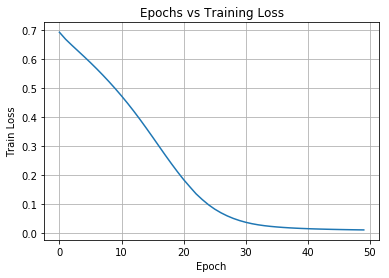

In [443]:
plt.plot(np.arange(epochs),train_loss_history)
plt.title('Epochs vs Training Loss')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.show()

## We are overfitting

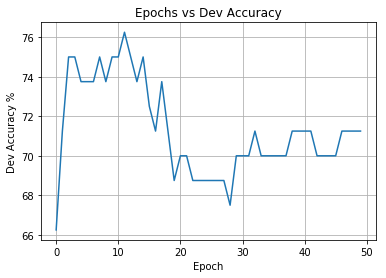

In [444]:
plt.plot(np.arange(epochs),dev_acc_history)
plt.title('Epochs vs Dev Accuracy')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Dev Accuracy %")
plt.show()

### Early stopping helps to stop the training if the validation set error starts to rise. Helps to avoid over-fitting

In [461]:
train_tags,train_sentences = readSentences("data/numpred.train")
t_tags,t_sents = sampleSentences(train_tags,train_sentences,0.1,True)
embedding_dim = 50
hidden_dim = 50
tagset_size=2
batch_size = 20
epochs = 10
dev_size = 3000
print_every_epoch=False
early_stop=True
sample_dev=True
learning_rates = [0.01,0.001,0.002,0.005,0.0001]
train_loss_histories =[]
dev_acc_histories=[]
models = []
for learning_rate in learning_rates:
    print("Trainging for Learning Rate: "+str(learning_rate))
    model,train_loss_history,dev_loss_history,dev_acc_history=trainModel(embedding_dim,hidden_dim,tagset_size,batch_size,dev_size,t_tags,t_sents,[],[],epochs,print_every_epoch,early_stop,sample_dev,learning_rate)
    train_loss_histories.append(train_loss_history)
    dev_acc_histories.append(dev_acc_history)
    models.append(model)

Trainging for Learning Rate: 0.01
Trainging for Learning Rate: 0.001
Trainging for Learning Rate: 0.002
Trainging for Learning Rate: 0.005
Trainging for Learning Rate: 0.0001


## Choosing the best learning rate

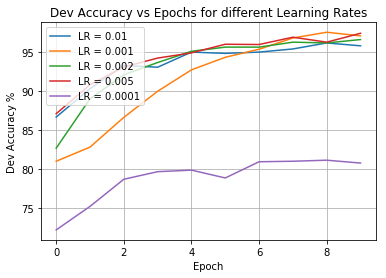

In [463]:
x = np.arange(epochs)
plt.plot(x,dev_acc_histories[0])
plt.plot(x,dev_acc_histories[1])
plt.plot(x,dev_acc_histories[2])
plt.plot(x,dev_acc_histories[3])
plt.plot(x,dev_acc_histories[4])
plt.title('Dev Accuracy vs Epochs for different Learning Rates')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Dev Accuracy %")

plt.legend(['LR = 0.01', 'LR = 0.001', 'LR = 0.002', 'LR = 0.005','LR = 0.0001'], loc='upper left')
plt.show()

In [464]:
print(dev_acc_histories[1])
print(train_loss_histories[1])

[81.00671140939598, 82.81879194630872, 86.64429530201342, 90.0, 92.75167785234899, 94.36241610738256, 95.40268456375838, 96.84563758389262, 97.58389261744966, 97.11409395973153]
[0.498168890719337, 0.41563890487861976, 0.362001395182874, 0.28192138671875, 0.20780579050026554, 0.14632993094183253, 0.10592964595460294, 0.08852904427243473, 0.07380997686778497, 0.0597946972241342]


### Count of attractors are the number of nouns of the opposite number that appear between the subject and verb. More the number of these attractors, more is the model confused

In [483]:
def calculateTestError(test_tags,test_sents,batch_size,word_to_idx,tag_to_idx,max_length,model):
    index=0
    t_minibatches = 0
    correct = 0
    total = 0
    total_loss = 0
    softmax = nn.Softmax(dim=1)
    while(index+batch_size<len(test_sents)):
        minibatch = test_sents[index:index+batch_size]
        input_seqs = []
        input_sizes = []
        for sen in minibatch:
            sen_seq,size = prepare_sequence(sen, word_to_idx,max_length)
            input_seqs.append(sen_seq)
            input_sizes.append(size)
        sorted_idx = np.argsort(input_sizes)[::-1]
        input_sizes=[input_sizes[i] for i in sorted_idx]
        input_seqs = [input_seqs[i] for i in sorted_idx]
        input_seqs = torch.cat(input_seqs,0).view(batch_size,max_length)
        t_tags = [tag_to_idx[test_tags[i]] for i in range(index,index+batch_size)]
        t_tags = [t_tags[i] for i in sorted_idx]
        tags_seq = autograd.Variable(torch.LongTensor(t_tags))
        model.hidden = model.init_hidden()
        t_out = model(input_seqs,input_sizes,batch_size)
        t_loss = loss_function(t_out[0],tags_seq)
        total_loss+=t_loss.data
        t_minibatches+=1
        index+=batch_size
            
        total+=len(t_tags)
        sm = softmax(t_out[0])
        values, t_indices = sm.max(1)
        t_correct = (t_indices == tags_seq).sum()
        correct+=int(t_correct)
    return float(correct/total*100.0)
    

In [494]:
vocabulary,word_to_idx,idx_to_word,tag_to_idx,idx_to_tag,max_length = processTrainingSet(t_tags,t_sents)
model = models[1]
test_tags0,test_sentences0 = readSentences("data/numpred.test.0")
test_tags1,test_sentences1 = readSentences("data/numpred.test.1")
test_tags2,test_sentences2 = readSentences("data/numpred.test.2")
test_tags3,test_sentences3 = readSentences("data/numpred.test.3")
test_tags4,test_sentences4 = readSentences("data/numpred.test.4")
test_tags5,test_sentences5 = readSentences("data/numpred.test.5")

test_tags0,test_sentences0 = sampleTestSentences(test_tags0,test_sentences0,2000,False,max_length)
test_tags1,test_sentences1 = sampleTestSentences(test_tags1,test_sentences1,2000,False,max_length)
test_tags2,test_sentences2 = sampleTestSentences(test_tags2,test_sentences2,2000,False,max_length)
test_tags3,test_sentences3 = sampleTestSentences(test_tags3,test_sentences3,2000,False,max_length)
test_tags4,test_sentences4 = sampleTestSentences(test_tags4,test_sentences4,1,True,max_length)
test_tags5,test_sentences5 = sampleTestSentences(test_tags5,test_sentences5,1,True,max_length)

In [503]:
acc0 =calculateTestError(test_tags0,test_sentences0,20,word_to_idx,tag_to_idx,max_length,model)
acc1 =calculateTestError(test_tags1,test_sentences1,20,word_to_idx,tag_to_idx,max_length,model)
acc2 =calculateTestError(test_tags2,test_sentences2,20,word_to_idx,tag_to_idx,max_length,model)
acc3 =calculateTestError(test_tags3,test_sentences3,20,word_to_idx,tag_to_idx,max_length,model)
acc4 =calculateTestError(test_tags4,test_sentences4,20,word_to_idx,tag_to_idx,max_length,model)
acc5 =calculateTestError(test_tags5,test_sentences5,20,word_to_idx,tag_to_idx,max_length,model)


In [504]:
acc0 = 100 - acc0
acc1 = 100 - acc1
acc2 = 100 - acc2
acc3 = 100 - acc3
acc4 = 100 - acc4
acc5 = 100 - acc5

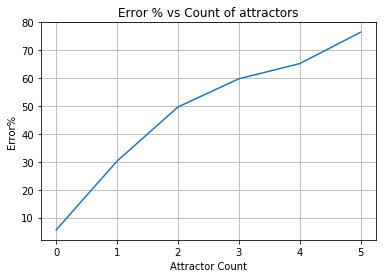

In [505]:
x = np.arange(6)
plt.plot(x,[acc0,acc1,acc2,acc3,acc4,acc5])
plt.title('Error % vs Count of attractors')
plt.grid()
plt.xlabel("Attractor Count")
plt.ylabel("Error%")
plt.show()

### Finding some incorrect results. Note the Test accuracy is about 96% in the case of no attractors.

In [519]:
def findIncorrectResults(test_tags,test_sents,batch_size,word_to_idx,tag_to_idx,max_length,model):
    index=0
    t_minibatches = 0
    correct = 0
    total = 0
    total_loss = 0
    softmax = nn.Softmax(dim=1)
    sentences = []
    while(index+batch_size<len(test_sents)):
        minibatch = test_sents[index:index+batch_size]
        input_seqs = []
        input_sizes = []
        for sen in minibatch:
            sen_seq,size = prepare_sequence(sen, word_to_idx,max_length)
            input_seqs.append(sen_seq)
            input_sizes.append(size)
        sorted_idx = np.argsort(input_sizes)[::-1]
        input_sizes=[input_sizes[i] for i in sorted_idx]
        input_seqs = [input_seqs[i] for i in sorted_idx]
        input_seqss = torch.cat(input_seqs,0).view(batch_size,max_length)
        t_tags = [tag_to_idx[test_tags[i]] for i in range(index,index+batch_size)]
        t_tags = [t_tags[i] for i in sorted_idx]
        tags_seq = autograd.Variable(torch.LongTensor(t_tags))
        model.hidden = model.init_hidden()
        t_out = model(input_seqss,input_sizes,batch_size)
        t_loss = loss_function(t_out[0],tags_seq)
        total_loss+=t_loss.data
        t_minibatches+=1
        index+=batch_size
            
        total+=len(t_tags)
        sm = softmax(t_out[0])
        values, t_indices = sm.max(1)
        t_correct = (t_indices == tags_seq).sum()
        correct+=int(t_correct)
        for i in range(20):
            if int(t_indices[i])!=int(tags_seq[i]):
                sentences.append(minibatch[sorted_idx[i]])
        if(len(sentences)==10):
            break
    return sentences

In [525]:
sentences =findIncorrectResults(test_tags0,test_sentences0,20,word_to_idx,tag_to_idx,max_length,model)
sentences

['the JJ NN family NNP contains VBZ which as adults',
 'NN became the schools first',
 'capital letters',
 'although addiction',
 'this album cover ( front only ) is presented at low resolution and does not VB upon the copyright holders',
 'the regulations',
 'its NN fishing harbour still',
 'the specialists',
 'because of his vast knowledge of the JJ world , he knows exactly what he needs to do to have his talents',
 'NNP tubes generally']

### Let's see PCA visualisation of plural and singual words from the model's embedding matrix.

In [550]:
from nltk.corpus import brown
import nltk
import operator
from sklearn.decomposition import PCA as sklearnPCA


tagged_words = brown.tagged_words()
singular = ["michael", "actor", "man", "book", "prison"]
plural = ["regions", "programs", "homes", "tigers", "keywords"]

In [548]:
NN = []
NNS = []
for (word,tag) in tagged_words:
    if tag =="NN":
        NN.append(word)
    if tag == "NNS":
        NNS.append(word)

In [561]:
fdistNN = nltk.FreqDist(w.lower() for w in NN)
sorted_NN = sorted(fdistNN.items(), key=operator.itemgetter(1),reverse=True)
fdistNNS = nltk.FreqDist(w.lower() for w in NNS)
sorted_NNS = sorted(fdistNNS.items(), key=operator.itemgetter(1),reverse=True)

for (NNItem,val) in sorted_NN:
    singular.append(NNItem)
    if len(singular) >100:
        break
for (NNSItem,val) in sorted_NNS:
    plural.append(NNSItem)
    if len(plural) >100:
        break


### Section 3.9

In [595]:
model = models[1]
embeddings=model.word_embeddings
singular_idx = []
plural_idx = []
for i in singular:
    if i in word_to_idx:
        singular_idx.append(word_to_idx[i])
    else:
        singular_idx.append(word_to_idx["OOV"])

for i in plural:
    if i in word_to_idx:
        plural_idx.append(word_to_idx[i])
    else:
        plural_idx.append(word_to_idx["OOV"])

singular_matrix = embeddings(autograd.Variable(torch.LongTensor(singular_idx)))
plural_matrix = embeddings(autograd.Variable(torch.LongTensor(plural_idx)))



In [596]:
singular_matrix = singular_matrix.data.numpy()
plural_matrix = plural_matrix.data.numpy()
pca = sklearnPCA(n_components=2)
sing_pca = pca.fit_transform(singular_matrix)
plu_pca = pca.fit_transform(plural_matrix)

In [597]:
sing_x = []
sing_y = []
plu_x = []
plu_y = []
for i in sing_pca:
    sing_x.append(i[0])
    sing_y.append(i[1])
    
for i in plu_pca:
    plu_x.append(i[0])
    plu_y.append(i[1])

## Singulars and plurals in fact have different axis

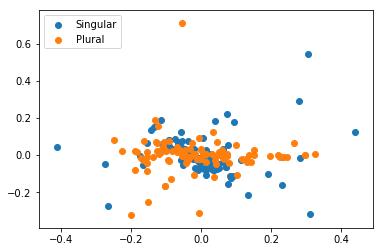

In [601]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(sing_x, sing_y, label='Singular')
ax1.scatter(plu_x,plu_y,  label='Plural')
plt.legend(loc='upper left');
plt.show()